<a href="https://colab.research.google.com/github/KhizarAziz/RP/blob/master/Research_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + '0dev_folder/Data/'
colab_base_dir = '/content/'

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import shutil
import os
import dlib
from pathlib import Path
import feather
# from m_preprocess_dataset.pose import get_rotation_angle
import pickle
# import fastai.vision

# **Test Our-Dataset Accuracy (Professor demand)**

In [ ]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
!wget https://api.wandb.ai/files/khizerawan/rp/3oxb4n5p/model-best.h5 -O morph.h5 #https://wandb.ai/khizerawan/rp/runs/3oxb4n5p/files?workspace=user-khizerawan
!wget https://api.wandb.ai/files/khizerawan/rp/3d1dni9v/model-best.h5 -O fgnet.h5 #https://wandb.ai/khizerawan/rp/runs/3d1dni9v?workspace=user-khizerawan
!wget https://api.wandb.ai/files/khizerawan/rp/2iw9pbaf/model-best.h5 -O imdb.h5 # https://wandb.ai/khizerawan/rp/runs/2iw9pbaf/files?workspace=user-khizerawan
!wget https://api.wandb.ai/files/khizerawan/rp/315y4bqn/model-best.h5 -O our.h5  #https://wandb.ai/khizerawan/rp/runs/315y4bqn?workspace=user-khizerawan    

In [ ]:
# load model weights
model_our = keras.models.load_model('our.h5', custom_objects={'tf': tf})
model_fgnet = keras.models.load_model('fgnet.h5', custom_objects={'tf': tf})
model_morph = keras.models.load_model('morph.h5', custom_objects={'tf': tf})
model_imdb = keras.models.load_model('imdb.h5', custom_objects={'tf': tf})

In [ ]:
!git clone https://github.com/KhizarAziz/RP.git



> ## **`Inference`**






In [ ]:
detector = dlib.cnn_face_detection_model_v1('/content/RP/detect/mmod_human_face_detector.dat')
predictor = dlib.shape_predictor("/content/RP/detect/shape_predictor_68_face_landmarks.dat")

def detect_faces_and_landmarks(image):
  face_rect_list = detector(image)
  img_face_count = len(face_rect_list) # number of faces found in image
  if img_face_count < 1:
    print('no face found, so return ')
    return 0,[],[] # no face found, so return 

  xmin, ymin, xmax, ymax = face_rect_list[0].rect.left() , face_rect_list[0].rect.top(), face_rect_list[0].rect.right(), face_rect_list[0].rect.bottom() # face_rect is dlib.rectangle object, so extracting values from it
  
  # make a landmarks_list of all faces detected in image
  lmarks_list = dlib.full_object_detections()
  for face_rect in face_rect_list:
    lmarks_list.append(predictor(image, face_rect.rect)) # getting landmarks as a list of objects
  
  return img_face_count,np.array([xmin, ymin, xmax, ymax]), lmarks_list


########################### 3 face generator by pose aware cropper
def get_margin_right_left(landmarks,gap_margin):
  total_distance,nose_to_left = landmarks[16][0]-landmarks[0][0], landmarks[30][0] - landmarks[0][0]
  percent_left = nose_to_left*100/total_distance
  left_margin = round(gap_margin * percent_left/100)
  right_margin = gap_margin-left_margin
  if gap_margin < 0: # nagtive margin means inner-outer
    return right_margin,left_margin
  else: # positive or 0 margine means outer-inner
    return left_margin,right_margin 

def get_margin_up_down_split(gap_margin,down_split=0.3):
  # calculate margin values for up & down side.
  down_margin = round(gap_margin * down_split)
  up_margin = gap_margin-down_margin
  return up_margin,down_margin


def evaluate_face_box(x1,y1,x2,y2,landmarks, force_align =False):
  left_lm = landmarks[17][0] # left side of face
  right_lm = landmarks[26][0] # right side of face
  top_lm = landmarks[24][1] # top side of face
  down_lm = landmarks[57][1] # bottom side of face
  if (left_lm < x1) or (right_lm > x2) or force_align:
    avg_offset_h = int (((x1 - left_lm) + (x2 - right_lm))/2)
    x1 -= avg_offset_h
    x2 -= avg_offset_h
  if (top_lm < y1) or (down_lm > y2) or force_align:
    avg_offset_v = int (((y1 - top_lm) + (y2 - down_lm))/2)
    y1 -= avg_offset_v
    y2 -= avg_offset_v
  return x1,y1,x2,y2

def gen_triple_face_box(box,landmarks,percent_margin=10):
  xmin, ymin, xmax, ymax = box 
  h = xmax - xmin
  gap_margin = round(h * percent_margin/100)
  left_margin,right_margin = get_margin_right_left(landmarks,gap_margin)
  if right_margin != 0:
    if 0.66 < left_margin/right_margin < 1.55:
      xmin, ymin, xmax, ymax = evaluate_face_box(xmin, ymin, xmax, ymax, landmarks,force_align=True) 
    else:
      xmin, ymin, xmax, ymax = xmin-5, ymin-5, xmax+5, ymax+5
  box_array = [[(xmin,ymin),(xmax,ymax)]]
  
  # middle box
  left_margin,right_margin = get_margin_right_left(landmarks,gap_margin) # calculate gap_margin right and left
  up_margin , down_margin  = get_margin_up_down_split(gap_margin)
  new_X =  int(xmin - left_margin)
  new_Y = int(ymin - up_margin)
  new_X2 = int(xmax + right_margin)
  new_Y2 = int(ymax + down_margin)
  new_X,new_Y,new_X2,new_Y2 = evaluate_face_box(new_X,new_Y,new_X2,new_Y2,landmarks,force_align=True)
  box_array.append([(new_X,new_Y),(new_X2,new_Y2)])
  # outer box
  gap_margin = gap_margin*-1.3 # because 3rd box will be further outside
  left_margin,right_margin = get_margin_right_left(landmarks,gap_margin) # calculate gap_margin right and left
  up_margin , down_margin  = get_margin_up_down_split(gap_margin)
  new_X = int(xmin - left_margin)
  new_Y = int(ymin - up_margin)
  new_X2 =int(xmax + right_margin)
  new_Y2 =int(ymax + down_margin)
  new_X,new_Y,new_X2,new_Y2 = evaluate_face_box(new_X,new_Y,new_X2,new_Y2,landmarks)
  box_array.append([(new_X,new_Y),(new_X2,new_Y2)])
  return np.array(box_array)

In [ ]:
img = cv2.imread('/content/Baber_Official.png')
try:
    face_count, bounds, face_landmarks_object_list = detect_faces_and_landmarks(img)
    first_landmark_object = face_landmarks_object_list[0]
    landmarks_list = np.array([[point.x,point.y] for point in first_landmark_object.parts()]) # Same converting landmarks (face_detection_object) to array so can be converted to json
except Exception as e:
  print("Exception: Couldnt run detect_faces_and_landmarks cuz ",e)

In [ ]:
trible_box = gen_triple_face_box(bounds,landmarks_list,percent_margin=10)#gen_boundbox(bounds, landmarks)
tri_imgs = []
temp_imgs = []
for bbox in trible_box:
    bbox = bbox #+ padding
    h_min, w_min = bbox[0]
    h_max, w_max = bbox[1]
    cropped_img = cv2.resize(img[w_min:w_max, h_min:h_max], (64, 64))
    temp_imgs.append(cropped_img)
    tri_imgs.append(np.expand_dims(cropped_img,axis=0))
print(np.array(tri_imgs).shape,np.array(temp_imgs).shape)

(3, 1, 64, 64, 3) (3, 64, 64, 3)


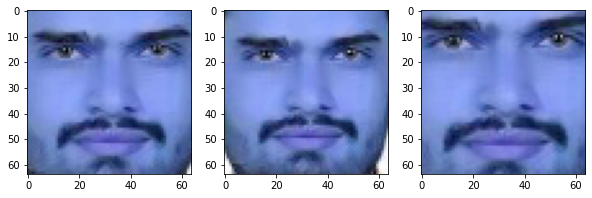

In [ ]:
# train on old datset, and see if accruacy is same
f,axarr = plt.subplots(nrows=1,ncols=3,figsize=(10,10))
for i in range(3):
    imgz = temp_imgs[i]
    # axarr[i].set_title(str(Accepted_List[i].shape),fontsize = 20)
    axarr[i].imshow(imgz)
#f.savefig('/content/test.jpg')

In [ ]:
result_our = model_our.predict(tri_imgs)
result_fgnet = model_fgnet.predict(tri_imgs)
result_morph = model_morph.predict(tri_imgs)
result_imdb = model_imdb.predict(tri_imgs)

In [ ]:
print(f'fgnet: {result_fgnet[0]}  moprh: {result_morph[0]}    imdb: {result_imdb[0]}   our: {result_our[0]}')

fgnet: [[29.381268]]  moprh: [[25.627586]]    imdb: [[23.01025]]   our: [[27.900494]]





> ## **Preprocess WIKI Dataset**





In [ ]:
cd RP

/content/RP


In [ ]:
from m_net_training import C3AE_net
from m_net_training import training_utils

In [ ]:
# Loading dataset (from .feather file)
dataset_dir = Path('/content/gdrive/MyDrive/Prep-Processed-Datasets/wiki-preprocessed')
dataset_df = pd.DataFrame(columns=["image_path","age", "gender", "image", "org_box", "landmarks"])
for fnames in dataset_dir.glob('*.feather'):
  #ashutil.copy(fnames,'/content/gdrive/MyDrive/Prep-Processed-Datasets/own-data-preprocessed/')
  df_chunk = feather.read_dataframe(dataset_dir.joinpath(fnames))
  dataset_df = pd.concat([dataset_df,df_chunk],ignore_index=True)
dataset_df = dataset_df[['image_path','age','gender','image','org_box','landmarks']]
dataset_df = dataset_df.astype({'age': 'float64'})
dataset_df.shape
# dataset_df.hist()

(30378, 6)

In [ ]:
#validation split using sklearn.model_selection's train_test_split method
# trainset, testset = train_test_split(dataset_df, train_size=0.9, test_size=0.1, random_state=config.seed)
# dataset_df = pd.DataFrame()

In [ ]:
input_shape = (64,64)
category = 12
interval = 10
train_gen = training_utils.img_and_age_data_generator(dataset_df,batch_size=32,category=category,interval=interval,imgs_shape=input_shape,random_erasing=False,random_enforcing=False,dropout=0.2,pose_aware_cropper=True,gap_margin=10)

58.0


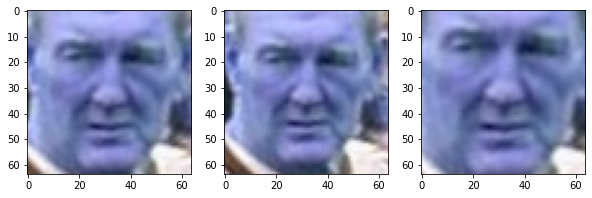

In [ ]:
# train on old datset, and see if accruacy is same
index = 1
first_batch = next(iter(train_gen))
Accepted_List = [first_batch[0][0][index],first_batch[0][1][index],first_batch[0][2][index]] # list of [image_path,age]
print(first_batch[1][0][index])
f,axarr = plt.subplots(nrows=1,ncols=3,figsize=(10,10))
for i in range(3):
    img = Accepted_List[i]
    # axarr[i].set_title(str(Accepted_List[i].shape),fontsize = 20)
    axarr[i].imshow(img)
#f.savefig('/content/test.jpg')

In [ ]:
result_our = model_our.evaluate(train_gen,batch_size=64,steps=1000)
result_our[3]

1000/1000 [==============================] - 43s 43ms/step - loss: 15.6247 - age_loss: 6.8735 - W1_loss: 0.8751 - age_age_mean_absolute_error: 6.8735 - W1_W1_accuracy: 0.4199


6.873486518859863

In [ ]:
result_fgnet = model_fgnet.evaluate(train_gen,batch_size=64,steps=1000)
result_fgnet[3]

1000/1000 [==============================] - 43s 43ms/step - loss: 65.8360 - age_loss: 16.5729 - W1_loss: 4.9263 - age_age_mean_absolute_error: 16.5729 - W1_W1_accuracy: 0.1929


16.572856903076172

In [ ]:
result_morph= model_morph.evaluate(train_gen,batch_size=64,steps=1000)
result_morph[3]

1000/1000 [==============================] - 42s 42ms/step - loss: 37.1963 - age_loss: 11.2041 - W1_loss: 2.5992 - age_age_mean_absolute_error: 11.2041 - W1_W1_accuracy: 0.2851


11.204084396362305

In [ ]:
result_imdb= model_imdb.evaluate(train_gen,batch_size=64,steps=1000)
result_imdb[3]

1000/1000 [==============================] - 42s 42ms/step - loss: 15.4357 - age_loss: 6.7104 - W1_loss: 0.8725 - age_age_mean_absolute_error: 6.7104 - W1_W1_accuracy: 0.4329


6.710384845733643

In [ ]:
filename = '/content/gdrive/MyDrive/Final_Dataset/3.tar.gz'
csv_path = '/content/gdrive/MyDrive/Final_Dataset/dataset-meta.csv'

In [ ]:
new_path = shutil.copy(filename,'/content/')
print('copied file',new_path)
shutil.unpack_archive(new_path,'/content/RP/dataset/Dataset/')
# shutil.copy(csv_path,'/content/RP/dataset/Dataset/dataset-meta.csv')

copied file /content/3.tar.gz


In [ ]:
df = pd.read_csv('/content/RP/dataset/Dataset/dataset-meta.csv')
df = df[df['imgPath'].str.contains('Dataset/3/')]
df['imgPath'] = '/content/RP/dataset/'+df['imgPath']

In [ ]:
df.head()

,nconst,age,gender,country,imageName,imgPath
1274208,nm0171583,68,F,"Fajardo, Puerto Rico",epb359.jpg,/content/RP/dataset/Dataset/3/nm0171583/epb359...
1274209,nm0171583,71,F,"Fajardo, Puerto Rico",r0hnt6.jpg,/content/RP/dataset/Dataset/3/nm0171583/r0hnt6...
1274210,nm0171583,67,F,"Fajardo, Puerto Rico",e0kft1.jpg,/content/RP/dataset/Dataset/3/nm0171583/e0kft1...
1274211,nm0171583,67,F,"Fajardo, Puerto Rico",e0kgy3.jpg,/content/RP/dataset/Dataset/3/nm0171583/e0kgy3...
1274212,nm0171583,68,F,"Fajardo, Puerto Rico",ep7gj5.jpg,/content/RP/dataset/Dataset/3/nm0171583/ep7gj5...


In [ ]:
index += 15
print(df['age'].iloc[index])
img = df['imgPath'].iloc[index]
plt.imshow(cv2.imread(img))

In [ ]:
obj = DeepFace.analyze(img_path = img, actions = ['age', 'gender'])
print(obj["age"]," years old  ", obj["gender"])

In [ ]:
agender = PyAgender()
faces = agender.detect_genders_ages(cv2.imread(img))
print(faces)

In [ ]:
#delete broughted data
shutil.rmtree('/content/RP/dataset/Dataset/8')

# **Setup Dataset**

In [ ]:
!git clone https://github.com/KhizarAziz/RP.git #clone repo

In [ ]:
import shutil
#WIKI
# shutil.copy('/content/gdrive/My Drive/0dev_folder/Previous Datasets/wiki_crop.tar', '/content/')
# IMDB
shutil.copy('/content/gdrive/My Drive/0dev_folder/Previous Datasets/imdb_crop.tar', '/content/')
# morph
# shutil.copy('/content/gdrive/My Drive/0dev_folder/Previous Datasets/Morph.tar', '/content/')

In [ ]:
cd /content/

In [ ]:
#extract datasets
!tar -xvf imdb_crop.tar -C /content/RP/dataset
# !tar -xvf wiki_crop.tar -C /content/RP/dataset
# morph data
# !tar -xvf Morph.tar -C /content/RP/dataset

In [ ]:
cd /content/RP/

/content/RP


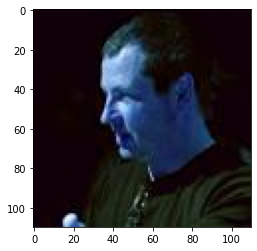

In [ ]:
plt.imshow(cv2.imread('/content/RP/dataset/imdb_crop/02/nm0000002_rm3224279040_1924-9-16_2005.jpg'))

In [ ]:
#Wiki-IDMB
!python /content/RP/m_preprocess_dataset/pre_process_WIKI-IMDB.py
#Morph
# !python /content/RP/m_preprocess_dataset/pre_process_Morph.py

In [ ]:
p = Path('/content')
for f in p.glob('*.jpg'):
  os.remove(f)

# **PlayGround**

In [ ]:
cd /content/RP

/content/RP


In [ ]:
import math
from m_net_training import C3AE_net
from m_net_training import training_utils
# from m_net_training.training_utils import CyclicLR
import feather
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau
from keras.losses import kl_divergence,mae,binary_crossentropy
from keras.metrics import mae,Accuracy
import tensorflow as tf

In [ ]:
# initializing params
# log_dir = './logs'
r_factor = 2
category = 10
dropout = 0.2
train_split = 0.8
test_split = round(1 - train_split,2)
seed = 2019
category = category + 2
interval = 10#int(math.ceil(100. / category))

In [ ]:
# Loading dataset (from .feather file)
dataset_dir = Path('/content/gdrive/MyDrive/Prep-Processed-Datasets/imdb-preprocessed')
dataset_df = pd.DataFrame(columns=["image_path","age", "gender", "image", "org_box", "landmarks"])
for fnames in dataset_dir.glob('*.feather'):
  #ashutil.copy(fnames,'/content/gdrive/MyDrive/Prep-Processed-Datasets/own-data-preprocessed/')
  df_chunk = feather.read_dataframe(dataset_dir.joinpath(fnames))
  dataset_df = pd.concat([dataset_df,df_chunk],ignore_index=True)
dataset_df = dataset_df.astype({'age': 'float64'})
dataset_df.shape

(121420, 12)

In [ ]:
#validation split using sklearn.model_selection's train_test_split method
trainset, testset = train_test_split(dataset_df, train_size=train_split, test_size=test_split, random_state=seed)

In [ ]:
import imp
imp.reload(training_utils)
#making a generator for image and dataset. inside generator we 
#load img, crop faces (3 sizes -> big,middle,small) then tranform (if aumentation is true) rotate,birhgt etc ect
#convert age into 2 point represenation (like on hot encoding, but has fractions)
input_shape = (64,64)
crop_margin = -20
pose_aware_cropper = True
batch_size = 32
random_erasing = False
random_enforcing = False
train_gen =     training_utils.img_and_age_data_generator(trainset,batch_size=batch_size,category=category,interval=interval,imgs_shape=input_shape,random_erasing=random_erasing,random_enforcing=random_enforcing,dropout=dropout,pose_aware_cropper=pose_aware_cropper,gap_margin=crop_margin)
validation_gen = training_utils.img_and_age_data_generator(testset,batch_size=batch_size,category=category,interval=interval,imgs_shape=input_shape,random_erasing=False,random_enforcing=False,dropout=0.0,pose_aware_cropper=pose_aware_cropper,gap_margin=crop_margin)
# print(trainset.groupby(["age"])["age"].agg("count"))

In [ ]:
index = 3
first_batch = next(iter(train_gen))
print(type(first_batch[1][0]),type(first_batch[1][1]))  # 2nd item -> 2nd item -> 1st item :::: (because i know this hierarchy)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/content/RP/m_net_training/training_utils.py:286: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  flag = random.randint(0, 3)


21.0


True

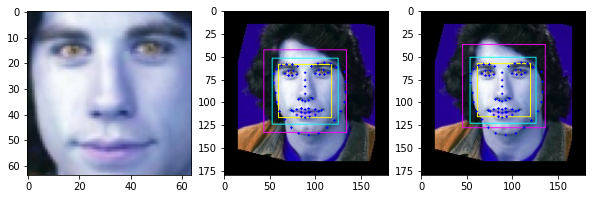

In [ ]:
# train on old datset, and see if accruacy is same
index += 1
Accepted_List = [first_batch[0][0][index],first_batch[0][1][index],first_batch[0][2][index]] # list of [image_path,age]
print(first_batch[1][0][index])
f,axarr = plt.subplots(nrows=1,ncols=3,figsize=(10,10))
a = []
for i in range(3):
    img = Accepted_List[i]
    # axarr[i].set_title(str(Accepted_List[i].shape),fontsize = 20)
    a.append(img)
    axarr[i].imshow(img)
# f.savefig('/content/test.jpg')
cv2.imwrite(f'/content/Demo_Cropper/{index}_Equal_Gen.jpg',a[1])
cv2.imwrite(f'/content/Demo_Cropper/{index}_Intl_Gen.jpg',a[2])

In [ ]:
p = Path('/content')
for f in p.glob('*.jpg'):
  os.remove(f)

In [ ]:
 padding = 15
  img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT)
  tripple_cropped_imgs = []
  # rr  = random.randint(0, 200)
  img_new = img.copy()
  test_img = img.copy()
  rand_1 = (0,255,255)
  rand_2 = (255,255,0)
  rand_3 = (255,0,255)
  color_arr = [rand_1,rand_2,rand_3]
  # for box in pickle.loads(row['trible_box'],encoding="bytes"): # deserializing object which we converted to binary format using myNumArray.dump() method
  i = 0
  for box in triple_box: # deserializing object which we converted to binary format using myNumArray.dump() method
    h_min, w_min = box[0] #xmin, ymin
    h_max, w_max = box[1] #xmax, ymax
    # print('img shape {} & trible box {} '.format(img.shape,box))
    # crop image according to box size and add to list
    triple_box_cropped = cv2.resize(img_new[w_min+padding:w_max+padding, h_min+padding: h_max+padding], target_img_shape) # cropping image
    imag = cv2.rectangle(test_img,(h_min+padding,w_min+padding),(h_max+padding, w_max+padding),color_arr[i],1)
    # triple_box_cropped = triple_box_cropped # resize according to size we want
    tripple_cropped_imgs.append(triple_box_cropped)
    i += 1

  for (x, y) in face_lm:
    cv2.circle(imag, (x+padding, y+padding), 1, (0, 0, 255), -1)
  
  tripple_cropped_imgs[2] = imag
  
  # try equal gen box
  triple_box = gen_equal_boundbox(face_box,percent_margin=gap_margin)
  i = 0
  img_new = img.copy()
  test_img = img.copy()
  for box in triple_box: # deserializing object which we converted to binary format using myNumArray.dump() method
    h_min, w_min = box[0] #xmin, ymin
    h_max, w_max = box[1] #xmax, ymax
    # print('img shape {} & trible box {} '.format(img.shape,box))
    # crop image according to box size and add to list
    # triple_box_cropped = cv2.resize(img_new[w_min+padding:w_max+padding, h_min+padding: h_max+padding], target_img_shape) # cropping image
    imag = cv2.rectangle(test_img,(h_min+padding,w_min+padding),(h_max+padding, w_max+padding),color_arr[i],1)
    # triple_box_cropped = triple_box_cropped # resize according to size we want
    # tripple_cropped_imgs.append(triple_box_cropped)
    i += 1

  for (x, y) in face_lm:
    cv2.circle(imag, (x+padding, y+padding), 1, (0, 0, 255), -1)
  
  tripple_cropped_imgs[1] = imag

IndentationError: ignored

# **Scatter plot for landmarks**

In [ ]:
index += 3
lmx = []
lmy = []
for p in pickle.loads(dataset_df["landmarks"].iloc[index],encoding="bytes"):
  lmx.append(p[0])
  lmy.append(p[1])
plt.scatter(lmx,lmy)
test_img_enc =np.frombuffer(dataset_df["image"].iloc[index], np.uint8)
test_img = cv2.cvtColor(cv2.imdecode(test_img_enc, cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
# triple_box
triple_box = pickle.loads(dataset_df["trible_box"].iloc[index],encoding="bytes")
for bbox in triple_box:
  bbox = bbox
  h_min, w_min = bbox[0]
  h_max, w_max = bbox[1]
  cv2.rectangle(test_img, (h_min,w_min), (h_max,w_max),(255,0,0),1)
plt.imshow(test_img)

In [ ]:
test_img_enc =np.frombuffer(dataset_df["image"].iloc[index], np.uint8)
test_img = cv2.cvtColor(cv2.imdecode(test_img_enc, cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)

# **SSR-Preprocessing**



> ## **`Test Faulty Images`**



In [ ]:
import shutil
#WIKI
shutil.copy('/content/gdrive/My Drive/0dev_folder/Previous Datasets/wiki_crop.tar', '/content/')
# IMDB
# shutil.copy('/content/gdrive/My Drive/0dev_folder/Previous Datasets/imdb_crop.tar', '/content/')
# morph
# shutil.copy('/content/gdrive/My Drive/0dev_folder/Previous Datasets/Morph.tar', '/content/')

'/content/wiki_crop.tar'

In [ ]:
cd /content/

/content


In [ ]:
#extract datasets
# !tar -xvf imdb_crop.tar -C /content/RP/dataset
!tar -xvf wiki_crop.tar -C /content/RP/dataset
# morph data
# !tar -xvf Morph.tar -C /content/RP/dataset

In [ ]:
# load all files from any folder of wiki
all_files = os.listdir('/content/RP/dataset/wiki_crop/00')
index = 1

In [ ]:
!pip install mtcnn
!pip install keras-facenet

In [ ]:
from mtcnn import MTCNN
from keras_facenet import FaceNet
import time

In [ ]:
# detector1 = MTCNN()
detector2 = dlib.cnn_face_detection_model_v1('/content/RP/detect/mmod_human_face_detector.dat')
# detector3 = FaceNet()
detector4 = dlib.get_frontal_face_detector()

In [ ]:
# load image
index = 1
# file_path = '/content/RP/dataset/wiki_crop/00/'+all_files[index]
test_img = cv2.imread('/content/DP.jpg')
img = test_img.copy()
# x1,y1,x2,y2 = detector2.detect_faces(img)[0]['box']
# img = cv2.rectangle(img,(x1,y1),(x2+x1,y2+y1),(255,0,0),2)
# plt.imshow(img)

In [ ]:
#dlib face detection
img = test_img.copy()
# start_time = time.time()
face_rect_list = detector2(img)
x1,y1,x2,y2 = face_rect_list[0].rect.left() , face_rect_list[0].rect.top(), face_rect_list[0].rect.right(), face_rect_list[0].rect.bottom() # face_rect is dlib.rectangle object, so extracting values from it
# print("--- %s seconds ---" % (time.time() - start_time))
img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(img)

In [ ]:
#dlib face detection
img = test_img.copy()
# start_time = time.time()
face_rect_list = detector4(img)
x1,y1,x2,y2 = face_rect_list[0].left() , face_rect_list[0].top(), face_rect_list[0].right(), face_rect_list[0].bottom() # face_rect is dlib.rectangle object, so extracting values from it
# print("--- %s seconds ---" % (time.time() - start_time))
img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(img)

In [ ]:
#mtcnn face detection
img = test_img.copy()
start_time = time.time()
x1,y1,x2,y2 = detector1.detect_faces(img)[0]['box']
print("--- %s seconds ---" % (time.time() - start_time))
img = cv2.rectangle(img,(x1,y1),(x2+x1,y2+y1),(255,0,0),2)
plt.imshow(img)
print(img[y1:y1+y2,x1:x1+x2].shape, img[y1:y1+y2,x1:x1+x2].shape[0]/img[y1:y1+y2,x1:x1+x2].shape[1])

In [ ]:
#face_net face detection
img = test_img.copy()
start_time = time.time()
x = detector3.extract(img, threshold=0.9)
x1,y1,x2,y2 = x[0]['box']
print("--- %s seconds ---" % (time.time() - start_time))
img = cv2.rectangle(img,(x1,y1),(x2+x1,y2+y1),(255,0,0),2)
plt.imshow(img)
print(img[y1:y1+y2,x1:x1+x2].shape, img[y1:y1+y2,x1:x1+x2].shape[0]/img[y1:y1+y2,x1:x1+x2].shape[1])

In [ ]:
img = test_img.copy()
predictor = dlib.shape_predictor("/content/RP/detect/shape_predictor_68_face_landmarks.dat")
# get pitch yaw role
_,box,lmarks = detect_faces_and_landmarks(img,detector4)
img = dlib.get_face_chips(img, lmarks, padding=0.8,size=350)[0]
_,box,lmarks = detect_faces_and_landmarks(img,detector4)
lm = [[point.x,point.y] for point in lmarks[0].parts()]
triple_box = gen_triple_face_box(box,lm,percent_margin=30)

# face_pitch, face_yaw, face_roll = get_rotation_angle(img, lmarks[0])
# face_pitch, face_yaw, face_roll
# triple_box = gen_box_PYR(box)
plt.figure()
plt.imshow(img)
cv2.imwrite('/content/org.jpg',img)
i = 0
for bbox in triple_box:
  bbox = bbox
  h_min, w_min = bbox[0]
  h_max, w_max = bbox[1]
  img_3 = img[w_min:w_max, h_min: h_max].copy()

  plt.figure()
  cv2.imwrite(f'/content/test{i}.jpg',img_3)
  i += 1
  plt.imshow(img_3)
  
  # cv2.rectangle(img, (h_min,w_min), (h_max,w_max),(255,0,0),2)

  # cv2.rectangle(img, (h_min,w_min), (h_max,w_max),(255,0,0),2)
# plt.imshow(img)

In [ ]:

def get_margin_right_left(landmarks,gap_margin):
  # gap_margin *=2 # because will be calculated on 2 sides
  # calculate percentange_of_right & percentange_of_left distance from total_distance
  total_distance,nose_to_left = landmarks[16][0]-landmarks[0][0], landmarks[30][0] - landmarks[0][0]
  percent_left = nose_to_left*100/total_distance
  # calculate margin values for right & left side.
  left_margin = round(gap_margin * percent_left/100)
  #confirmation of left+right == total_margin
  right_margin = gap_margin-left_margin
  return right_margin,left_margin

def get_margin_up_down_split(gap_margin,down_split=0.3):
  # calculate margin values for up & down side.
  down_margin = round(gap_margin * down_split)
  #confirmation of left+right == total_margin
  up_margin = gap_margin-down_margin
  return up_margin,down_margin


def evaluate_face_box(x1,y1,x2,y2,landmarks, force_align =False):
  left_lm = landmarks[17][0] # left side of face
  right_lm = landmarks[26][0] # right side of face
  top_lm = landmarks[24][1] # top side of face
  down_lm = landmarks[57][1] # bottom side of face
  
  
  if (left_lm < x1) or (right_lm > x2) or force_align:
    avg_offset_h = int (((x1 - left_lm) + (x2 - right_lm))/2)
    x1 -= avg_offset_h
    x2 -= avg_offset_h

  if (top_lm < y1) or (down_lm > y2) or force_align:
    avg_offset_v = int (((y1 - top_lm) + (y2 - down_lm))/2)
    y1 -= avg_offset_v
    y2 -= avg_offset_v

  return x1,y1,x2,y2

def gen_triple_face_box(box,landmarks,percent_margin=30):
  xmin, ymin, xmax, ymax = box 
  h = xmax - xmin
  #calculate gap value for bigger box
  gap_margin = round(h * percent_margin/100)
  
  # inner-box
  left_margin,right_margin = get_margin_right_left(landmarks,gap_margin)
  # print(left_margin,right_margin)
  if right_margin != 0:
    if 0.66 < left_margin/right_margin < 1.55:
      xmin, ymin, xmax, ymax = evaluate_face_box(xmin, ymin, xmax, ymax, landmarks,force_align=True) 
    else:
      xmin, ymin, xmax, ymax = xmin+50, ymin+50, xmax-50, ymax-50
    xmin, ymin, xmax, ymax = xmin+15, ymin+15, xmax-15, ymax-15
  box_array = [[(xmin,ymin),(xmax,ymax)]]
  
  # middle box
  left_margin,right_margin = get_margin_right_left(landmarks,gap_margin) # calculate gap_margin right and left
  up_margin , down_margin  = get_margin_up_down_split(gap_margin)
  new_X =  int(xmin - left_margin)
  new_Y = int(ymin - up_margin)
  new_X2 = int(xmax + right_margin)
  new_Y2 = int(ymax + down_margin)
  new_X,new_Y,new_X2,new_Y2 = evaluate_face_box(new_X,new_Y,new_X2,new_Y2,landmarks)
  box_array.append([(new_X,new_Y),(new_X2,new_Y2)])
  # outer box
  gap_margin = gap_margin*2 # because 3rd box will be further outside
  left_margin,right_margin = get_margin_right_left(landmarks,gap_margin) # calculate gap_margin right and left
  up_margin , down_margin  = get_margin_up_down_split(gap_margin)
  new_X = int(xmin - left_margin)
  new_Y = int(ymin - up_margin)
  new_X2 =int(xmax + right_margin)
  new_Y2 =int(ymax + down_margin)
  new_X,new_Y,new_X2,new_Y2 = evaluate_face_box(new_X,new_Y,new_X2,new_Y2,landmarks)
  box_array.append([(new_X,new_Y),(new_X2,new_Y2)])
  return np.array(box_array) 

In [ ]:
from m_preprocess_dataset.pose import get_rotation_angle
def gen_box_PYR(box,gap_margin=20):
  xmin, ymin, xmax, ymax = box 
  w, h = xmax - xmin, ymax - ymin

  box_array = [[(xmin,ymin),(xmax,ymax)]] # inner-box

  # middle box
  margin = int(h * gap_margin/100) # 15% margin
  new_X =  xmin - margin//2 
  new_Y = ymin - margin
  new_X2 = xmax + margin//2
  new_Y2 = ymax + margin 
  box_array.append([(new_X,new_Y),(new_X2,new_Y2)])

  # outer box
  margin = int(margin*2) # 30% margin
  new_X =  xmin - margin//2
  new_Y = ymin - margin
  new_X2 = xmax + margin//2 
  new_Y2 = ymax + margin 
  box_array.append([(new_X,new_Y),(new_X2,new_Y2)])

  return np.array(box_array) 


In [ ]:
def detect_faces_and_landmarks(image,detector):
  face_rect_list = detector(image,1)
  img_face_count = len(face_rect_list) # number of faces found in image
  if img_face_count < 1:
    # print('no faces detectedd,,   ',len(face_rect_list))
    return 0,[],[] # no face found, so return 

  xmin, ymin, xmax, ymax = face_rect_list[0].left() , face_rect_list[0].top(), face_rect_list[0].right(), face_rect_list[0].bottom() # face_rect is dlib.rectangle object, so extracting values from it
  predictor = dlib.shape_predictor("/content/RP/detect/shape_predictor_68_face_landmarks.dat")
  # make a landmarks_list of all faces detected in image
  lmarks_list = dlib.full_object_detections()
  for face_rect in face_rect_list:
    lmarks_list.append(predictor(image, face_rect)) # getting landmarks as a list of objects
  
  return img_face_count,np.array([xmin, ymin, xmax, ymax]), lmarks_list

In [ ]:
# create bounbox with his method - mtcnn
img = test_img.copy()
triple_box = gen_boundbox(x1,y1,x2+x1,y2+y1,x[0]['keypoints']['nose'])
for bbox in triple_box:
  bbox = bbox
  h_min, w_min = bbox[0]
  h_max, w_max = bbox[1]
  cv2.rectangle(img, (h_min,w_min), (h_max,w_max),(255,0,0),2)
plt.imshow(img)
# create bounbox with own method - dlib

# compare with screeenshots
# see whose result is better (having more head in image)

> ## **`Backup`**

In [ ]:
# --------------------------- TEST SSR -----------------------

def SE_BLOCK(input,using_SE=True,r_factor=2):
  channels_count = input.get_shape()[-1]
  act = GlobalAveragePooling2D()(input)
  fc1 = Dense(channels_count//r_factor,activation='relu')(act)
  scale = Dense(channels_count,activation='sigmoid')(fc1)
  return multiply([scale,input])

def CBRA(inputs):
  x = Conv2D(32,(3,3))(inputs)
  x = BatchNormalization(axis=-1)(x)
  x = Activation('relu')(x)
  x_layer = AveragePooling2D(2,2)(x)
  return x_layer

# stream 2 module
def CBTM(inputs):
  s = Conv2D(16,(3,3))(inputs)
  s = BatchNormalization(axis=-1)(s)
  s = Activation('tanh')(s)
  s_layer = MaxPooling2D(2,2)(s)   
  return s_layer


def PB(inputs):
  # s_layer2_mix = Flatten()(inputs)
  s_layer2_mix = GlobalAveragePooling2D()(inputs)
  s_layer2_mix = Dropout(0.1)(s_layer2_mix)
  s_layer2_mix = Dense(16,activation='relu')(s_layer2_mix)
  s_layer2_mix = Dense(3,activation='relu')(s_layer2_mix)
  return s_layer2_mix



def first_embd(x1,x2,isPB_Block=False):
  x = CBRA(x1)
  y = CBTM(x2)

  if isPB_Block:
    x = PB(x)
    y = PB(y)
    first_embd = Multiply()([x,y])
    return first_embd
  else:
    return x,y


def second_embd(x1,x2,isPB_Block=False):
  x,y = first_embd(x1,x2,False)

  x = CBRA(x)
  y = CBTM(y)

  if isPB_Block:
    x = PB(x)
    y = PB(y)
    scnd_embd = Multiply()([x,y])
    return scnd_embd
  else:
    return x,y


def third_embd(x1,x2):
  x,y = second_embd(x1,x2,False)

  x = CBRA(x)
  x = CBRA(x)
  y = CBTM(y)
  y = CBTM(y)

  x = PB(x)
  y = PB(y)
  scnd_embd = Multiply()([x,y])
  return scnd_embd




def build_ssr(Categories=12, input_height=64, input_width=64, input_channels=3, using_white_norm=True, using_SE=True):

  x1 = Input(shape=(input_height, input_width, input_channels))
  x1 = Lambda(white_norm,name='white_norm')(x1)
  x2 = Input(shape=(input_height, input_width, input_channels))
  x2 = Lambda(white_norm,name='white_norm')(x2)
  #--------- STREAM 1 ---------
  frst_embd = first_embd(x1,x2,isPB_Block=True)
  scnd_embd = second_embd(x1,x2,isPB_Block=True)
  thrd_embd = third_embd(x1,x2)


  cfeat = Concatenate(axis=-1)([frst_embd, scnd_embd,thrd_embd])
  bulk_feat = Dense(Categories, use_bias=True, activity_regularizer=regularizers.l1(0), activation='softmax', name="W1")(cfeat)
  age = Dense(1, name="age")(bulk_feat)

  return Model(inputs=[x1, x2], outputs=[age, bulk_feat])



In [ ]:
# I feel this one is better, Maybe because of multiple 16-16 Conv2D, I will try to add more smaller Conv2Ds

In [ ]:

def SE_BLOCK(input,using_SE=True,r_factor=2):
  channels_count = input.get_shape()[-1]
  act = GlobalAveragePooling2D()(input)
  fc1 = Dense(channels_count//r_factor,activation='relu')(act)
  scale = Dense(channels_count,activation='sigmoid')(fc1)
  return multiply([scale,input])

def CBRA(inputs):
  x = Conv2D(16,(3,3))(inputs)
  x = BatchNormalization(axis=-1)(x)
  x = Activation('relu')(x)
  x = Conv2D(16,(3,3))(inputs)
  x = BatchNormalization(axis=-1)(x)
  x = Activation('relu')(x)
  x_layer = AveragePooling2D(2,2)(x)
  return x_layer

# stream 2 module
def CBTM(inputs):
  s = Conv2D(16,(3,3))(inputs)
  s = BatchNormalization(axis=-1)(s)
  s = Activation('tanh')(s)
  x = Conv2D(16,(3,3))(inputs)
  x = BatchNormalization(axis=-1)(x)
  x = Activation('tanh')(x)
  s_layer = MaxPooling2D(2,2)(s)   
  return s_layer


def PB(inputs):
  # s_layer2_mix = Flatten()(inputs)
  s_layer2_mix = GlobalAveragePooling2D()(inputs)
  s_layer2_mix = Dropout(0.1)(s_layer2_mix)
  s_layer2_mix = Dense(16,activation='relu')(s_layer2_mix)
  s_layer2_mix = Dense(3,activation='relu')(s_layer2_mix)
  return s_layer2_mix



def first_embd(x1,x2,isPB_Block=False):
  x = CBRA(x1)
  y = CBTM(x2)

  if isPB_Block:
    x = PB(x)
    y = PB(y)
    first_embd = Multiply()([x,y])
    return first_embd
  else:
    return x,y


def second_embd(x1,x2,isPB_Block=False):
  x,y = first_embd(x1,x2,False)

  x = CBRA(x)
  y = CBTM(y)

  if isPB_Block:
    x = PB(x)
    y = PB(y)
    scnd_embd = Multiply()([x,y])
    return scnd_embd
  else:
    return x,y


def third_embd(x1,x2):
  x,y = second_embd(x1,x2,False)

  x = CBRA(x)
  x = CBRA(x)
  y = CBTM(y)
  y = CBTM(y)

  x = PB(x)
  y = PB(y)
  scnd_embd = Multiply()([x,y])
  return scnd_embd

# from IPython.core.debugger import set_trace
from IPython.core.debugger import set_trace


def build_ssr(Categories=12, input_height=64, input_width=64, input_channels=3, using_white_norm=True, using_SE=True):

  x1 = Input(shape=(input_height, input_width, input_channels))
  w1 = Lambda(white_norm,name='white_norm')(x1)
  x2 = Input(shape=(input_height, input_width, input_channels))
  w2 = Lambda(white_norm,name='white_norm_t')(x2)
  #--------- STREAM 1 ---------
  frst_embd = first_embd(x1,x2,isPB_Block=True)
  scnd_embd = second_embd(x1,x2,isPB_Block=True)
  thrd_embd = third_embd(x1,x2)


  cfeat = Concatenate(axis=-1)([frst_embd, scnd_embd,thrd_embd])
  bulk_feat = Dense(Categories, use_bias=True, activity_regularizer=regularizers.l1(0), activation='softmax', name="W1")(cfeat)
  age = Dense(1, name="age")(bulk_feat)

  return Model(inputs=[x1, x2], outputs=[age, bulk_feat])

In [ ]:
df_full = pd.read_csv('/content/Full_Dataset.csv')
df_filter = pd.read_csv('/content/Filtered_Dataset.csv')
n_df = df_full[df_full['gender'].isna()]

In [ ]:
n_df.head()

> ## **`DisplayImages`**

In [ ]:
Accepted_List = []
for index,row in n_df.iterrows():
  pth = row['image_path']
  age = row['age']
  Accepted_List.append([pth,age])

In [ ]:
Accepted_List[1][0]

In [ ]:
ySize = 5
xSize = 5
index = 30
f,axarr = plt.subplots(xSize,ySize,figsize=(20,20))
# f.suptitle(id, fontsize=100)
for i in range(xSize):
  for j in range(ySize):
    img = cv2.imread(Accepted_List[index][0])
    axarr[i,j].imshow(img)
    axarr[i,j].set_title(str(Accepted_List[index][1]),fontsize = 20)
    index += 1



> ## **`Custom Face_Align`**



In [ ]:
# dlib's face detecteto
predictor_path = '/content/C3AE/detect/shape_predictor_5_face_landmarks.dat'
face_file_path = '/content/Data Scientist.jpg'
detector = dlib.cnn_face_detection_model_v1('/content/C3AE/detect/mmod_human_face_detector.dat')
sp = dlib.shape_predictor(predictor_path)
img = dlib.load_rgb_image(face_file_path)
dets = detector(img, 1)

In [ ]:
# dlib lamrsk
faces = dlib.full_object_detections()
face = sp(img, dets[0].rect)
dlib_lmark = face.parts()
faces.append(face)

In [ ]:
images = dlib.get_face_chips(img, faces)
plt.imshow(images[0])

In [ ]:
!pip install mtcnn

In [ ]:
from mtcnn import MTCNN
mtcnn_detector = MTCNN()
from parts import parts

In [ ]:
#mtcnn lamrks box
detect_obj = mtcnn_detector.detect_faces(img)
#conveting mtcnn face_rect to dlib rect
p = detect_obj[0]['box']
my_rect = dlib.rectangle(p[0],p[1],p[0]+p[2],p[1]+p[3])
# dlib lamrsk with mtcnn box
faces = dlib.full_object_detections()
face = sp(img, my_rect)
dlib_lmark = face.parts()
faces.append(face)
images = dlib.get_face_chips(img, faces)
plt.imshow(images[0])

In [ ]:
#converting mtcnn lmarks to dlib points
pts = dlib.points(5)
# face_keys = list(detect_obj[0]['keypoints'].keys())
# i = 0
pts[3] = dlib.point(detect_obj[0]['keypoints']['left_eye'])
pts[0] = dlib.point(detect_obj[0]['keypoints']['right_eye'])
pts[2] = dlib.point(detect_obj[0]['keypoints']['nose'])
pts[4] = dlib.point(detect_obj[0]['keypoints']['mouth_left'])
pts[1] = dlib.point(detect_obj[0]['keypoints']['mouth_right'])
print(pts)
print(keys_face)
# while i < 5:
#   pnt = detect_obj[0]['keypoints'][face_keys[i]]
#   pts[i] = dlib.point(pnt) 
#   print(face_keys[i],pnt)
#   i+= 1
# for key in detect_obj[0]['keypoints']:
# x = detect_obj[0]['keypoints'][key]

In [ ]:
# mtcnn box+lmark, with dlib's get_chip
face = dlib.full_object_detection(my_rect,pts)
faces = dlib.full_object_detections()
faces.append(face)
images = dlib.get_face_chips(img, faces)
plt.imshow(images[0])

In [ ]:
dlib_lmark,pts

In [ ]:
#converting mtcnn lmarks to dlib points
pts = dlib.points(5)
i = 0
while i < 5:
  pts[i] = dlib.point(mtcnn_lm[i]) 
  i+= 1

In [ ]:
detect_obj[0]['keypoints']

In [ ]:
plt.imshow(img)

In [ ]:
# mtcn_lmarks = detect_obj[0]['keypoints']
# lmx = []
# lmy = []
# mtcnn_lm = []
# for key in mtcn_lmarks:
#   mtcnn_lm.append(mtcn_lmarks[key])
#   lmx.append(mtcn_lmarks[key][0])
#   lmy.append(mtcn_lmarks[key][1])
# plt.imshow(img)
# plt.scatter(lmx[:], lmy[:], s=10, marker='.', c='r')



# lmarks = sp(img, dets[0].rect).parts()
# lmx = []
# lmy = []
# for m in lmarks:
#   lmx.append(m.x)
#   lmy.append(m.y)
# plt.imshow(img)
# plt.scatter(lmx[:], lmy[:], s=10, marker='.', c='r')

In [ ]:
#-----------------------------



def SE_BLOCK(input,using_SE=True,r_factor=2):
  channels_count = input.get_shape()[-1]
  act = GlobalAveragePooling2D()(input)
  fc1 = Dense(channels_count//r_factor,activation='relu')(act)
  scale = Dense(channels_count,activation='sigmoid')(fc1)
  return multiply([scale,input])

def CBRA(inputs):
  x = Conv2D(16,(3,3))(inputs)
  x = BatchNormalization(axis=-1)(x)
  x = Activation('relu')(x)
  x = Conv2D(16,(3,3))(x)
  x = BatchNormalization(axis=-1)(x)
  x = Activation('relu')(x)
  x_layer = AveragePooling2D(2,2)(x)
  return x_layer

# stream 2 module
def CBTM(inputs):
  s = Conv2D(16,(3,3))(inputs)
  s = BatchNormalization(axis=-1)(s)
  s = LeakyReLU(alpha=0.1)(s)
  s = Conv2D(16,(3,3))(s)
  s = BatchNormalization(axis=-1)(s)
  s = LeakyReLU(alpha=0.1)(s)
  s_layer = MaxPooling2D(2,2)(s)   
  return s_layer


def PB(inputs):
  # s_layer2_mix = Flatten()(inputs)
  s_layer2_mix = GlobalAveragePooling2D()(inputs)
  s_layer2_mix = Dropout(0.1)(s_layer2_mix)
  s_layer2_mix = Dense(16,activation='relu')(s_layer2_mix)
  s_layer2_mix = Dense(3,activation='relu')(s_layer2_mix)
  return s_layer2_mix



def first_embd(x1,isPB_Block=False):
  x = CBRA(x1)
  y = CBTM(x1)

  if isPB_Block:
    x = PB(x)
    y = PB(y)
    first_embd = Multiply()([x,y])
    return first_embd
  else:
    return x,y


def second_embd(x1,isPB_Block=False):
  x,y = first_embd(x1,False)

  x = CBRA(x)
  y = CBTM(y)

  if isPB_Block:
    x = PB(x)
    y = PB(y)
    scnd_embd = Multiply()([x,y])
    return scnd_embd
  else:
    return x,y


def third_embd(x1):
  x,y = second_embd(x1,False)

  x = CBRA(x)
  x = CBRA(x)
  y = CBTM(y)
  y = CBTM(y)

  x = PB(x)
  y = PB(y)
  scnd_embd = Multiply()([x,y])
  return scnd_embd

# from IPython.core.debugger import set_trace
from IPython.core.debugger import set_trace


def build_ssr(Categories=12, input_height=64, input_width=64, input_channels=3, using_white_norm=True, using_SE=True):

  input_X = Input(shape=(input_height, input_width, input_channels))


  w1 = Lambda(white_norm,name='white_norm')(input_X)
  #--------- STREAM 1 ---------
  frst_embd = first_embd(w1,isPB_Block=True)
  scnd_embd = second_embd(w1,isPB_Block=True)
  thrd_embd = third_embd(w1)

  # set_trace()
  cfeat = Concatenate(axis=-1)([frst_embd, scnd_embd,thrd_embd])

  return Model(inputs=[input_X], outputs=[cfeat])



def build_model(Categories=12, input_height=64, input_width=64, input_channels=3, using_white_norm=True, using_SE=True):
  
  ssr_model = build_ssr(input_height=input_height,input_width=input_width,input_channels=input_channels, using_white_norm=using_white_norm, using_SE=using_SE)



  x1 = Input(shape=(input_height, input_width, input_channels))
  x2 = Input(shape=(input_height, input_width, input_channels))
  x3 = Input(shape=(input_height, input_width, input_channels))

  y1 = ssr_model(x1)
  y2 = ssr_model(x2)
  y3 = ssr_model(x3)

  # set_trace()
  
  cfeat = Concatenate(axis=-1)([y1, y2,y3])
  bulk_feat = Dense(Categories, use_bias=True, activity_regularizer=regularizers.l1(0), activation='softmax', name="W1")(cfeat)
  age = Dense(1, name="age")(bulk_feat)
  
  return Model(inputs=[x1,x2,x3], outputs=[age, bulk_feat])




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from wandb.keras import WandbCallback
from m_net_training import C3AE_net
from m_net_training import training_utils
import feather
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.losses import kl_divergence, MAE
from keras.metrics import mae, Accuracy
import tensorflow as tf


# initialize wandb with your project name and optionally with configutations.
category = 12
interval = 10
Age_Loss = 'mean_absolute_error'
CLR_METHOD = 'triangular'
MAX_LR = 0.01
MIN_LR = 1.000e-7
NUM_EPOCHS = 70
STEP_SIZE = 7
W1_Loss = 'kl_divergence'
architecture = 'architecture??'
batch_size = 64
dataset = 'wiki'
dropout = 0.2
img_ch = 3
img_h = 64
img_w = 64
random_enforcing = False
random_erasing = False
seed = 21
test_split = 0.2
train_split = 0.8
use_SE_block = True
use_white_norm = True


# Loading dataset (from .feather file)
dataset_dir = Path(f'/server4/gyl/Code/RP-master/dataset/{dataset}_crop')
dataset_df = pd.DataFrame(columns=["image_path", "age", "gender", "image", "org_box", "landmarks"])
for fnames in dataset_dir.glob('*.feather'):
    df_chunk = feather.read_dataframe(dataset_dir.joinpath(fnames))
    dataset_df = pd.concat([dataset_df, df_chunk], ignore_index=True)
dataset_df = dataset_df.astype({'age': 'float64'})
dataset_df.shape

trainset, testset = train_test_split(dataset_df, train_size=train_split, test_size=test_split,
                                     random_state=seed)

input_shape = (img_h, img_w)
train_gen = training_utils.img_and_age_data_generator(trainset, batch_size=batch_size, category=category,
                                                      interval=interval, imgs_shape=input_shape,
                                                      random_erasing=random_erasing,
                                                      random_enforcing=random_enforcing, dropout=dropout,
                                                      pose_aware_cropper=True, gap_margin=10)
validation_gen = training_utils.img_and_age_data_generator(testset, batch_size=batch_size, category=category,
                                                           interval=interval, imgs_shape=input_shape,
                                                           random_erasing=False, random_enforcing=False, dropout=0.0,
                                                           pose_aware_cropper=True, gap_margin=10)

index = 1
first_batch = next(iter(train_gen))
print(type(first_batch[1][0]), type(first_batch[1][1]))

index += 1
Accepted_List = [first_batch[0][0][index], first_batch[0][1][index], first_batch[0][2][index]]
print(first_batch[1][0][index])
f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
for i in range(3):
    img = Accepted_List[i]
    axarr[i].imshow(img)

age_distribution = [trainset["age"][(trainset.age >= x - 10) & (trainset.age <= x)].count() for x in range(10, 101, 10)]
age_distribution = [age_distribution[0]] + age_distribution + [age_distribution[-1]]
print(age_distribution)

import imp

imp.reload(C3AE_net)
tf.keras.backend.clear_session()
model = C3AE_net.build_model(Categories=category, using_SE=use_SE_block, using_white_norm=use_white_norm)

adam = Adam(lr=MIN_LR)
weight_factor = 10
model.compile(
    optimizer=adam,
    loss={'W1': W1_Loss, 'age': Age_Loss},
    metrics={"age": mae, "W1": 'accuracy'},
    loss_weights={'W1': weight_factor, 'age': 1}
)


class meriApniCustom_lr_history(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print('our lr is: {} '.format(lr))


save_path = '/server4/gyl/Code/RP-master/m_models_saved/morph-'
callbacks = [
    ModelCheckpoint(save_path + 'weights.{epoch:02d}-{val_age_mean_absolute_error:.2f}.hdf5',
                    monitor='val_age_mean_absolute_error',
                    verbose=1,
                    save_best_only=True,
                    model='min'),

    training_utils.CyclicLR(
        mode=CLR_METHOD,
        base_lr=MIN_LR,
        max_lr=MAX_LR,
        step_size=STEP_SIZE * (trainset.shape[0] // batch_size)),
    meriApniCustom_lr_history(),

]

history = model.fit(train_gen, steps_per_epoch=len(trainset) / batch_size, epochs=NUM_EPOCHS, callbacks=callbacks, validation_data=validation_gen, validation_steps=len(testset) / batch_size * 3)